# Import Packages

In [1]:
# General Packages
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Map Directories and Import NLTK Data

In [2]:
# Map src directory
import sys
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), "../."))
print("Root Directory: ", root_dir)
src_dir = os.path.join(root_dir,"src")
print("Src Directory: ", src_dir)
sys.path.append(src_dir)
data_dir = os.path.join(root_dir,"data")
print("Data Directory: ", data_dir)

Root Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder
Src Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/src
Data Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/data


In [3]:
# nltk.download('words', download_dir=venv_nltk_data_path)
# nltk.download('punkt_tab', download_dir=venv_nltk_data_path) # use punkt_tab instead of punkt to avoid pickling vulnerability
# nltk.download('stopwords',download_dir=venv_nltk_data_path)

In [4]:
venv_nltk_data_path = os.path.join(root_dir,'.venv/lib/nltk_data')
print("venv Data Path: ",venv_nltk_data_path)

try:
    os.mkdir(venv_nltk_data_path)
    try:
        nltk.download('words', download_dir=venv_nltk_data_path)
        nltk.download('punkt_tab', download_dir=venv_nltk_data_path) # use punkt_tab instead of punkt to avoid pickling security vulnerability
        nltk.download('stopwords',download_dir=venv_nltk_data_path)
        nltk.data.path.clear()
        nltk.data.path.append(venv_nltk_data_path)
    except:
        print("Error: Unable to download words")
except:
    print("Unable to create directory - it might already exist")
    pass


venv Data Path:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/nltk_data
Unable to create directory - it might already exist


# Import and Transform Data

In [5]:
training_df = pd.read_csv(os.path.join(data_dir, "processed", "training_df.csv"))

In [6]:
def concatenate_texts(row):
    cad_text = row['CAD_TEXT'] if pd.notna(row['CAD_TEXT']) else ""
    oh_text = row['OH1_TEXT'] if pd.notna(row['OH1_TEXT']) else ""
    
    if oh_text:  # If 'OH_TEXT' is not an empty string
        return cad_text + "POLICE NARRATIVE \n\n " + oh_text
    else:
        return cad_text  # If 'OH_TEXT' is empty, return only 'CAD_TEXT'

# Apply the function to the dataframe to create a new concatenated column
training_df['concatenated_text'] = training_df.apply(concatenate_texts, axis=1)
training_df = training_df[training_df['CRASH_SEVERITY_CD'].notnull() & training_df['CRASH_SEVERITY_CD'] !=0]
training_df['CRASH_SEVERE_IND'] = training_df['CRASH_SEVERITY_CD'].apply(
    lambda x: 1 if x in [1, 2] else 0
)

# Preprocess Text

In [7]:
# Preprocessing Packages
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

In [8]:
ps = PorterStemmer()
stopWords = set(nltk.corpus.stopwords.words('english'))
charfilter = re.compile('[a-zA-Z]+')

def CCR_Tokenizer(text):
    words = map(lambda word: word.lower(), nltk.word_tokenize(text))
    words = [word for word in words if word not in stopWords]
    tokens = (list(map(lambda token: ps.stem(token), words)))
    ntokens = list(filter(lambda token: charfilter.match(token), tokens))
    return ntokens

vec = TfidfVectorizer(tokenizer=CCR_Tokenizer, 
                      norm='l2', 
                      vocabulary=None,
                      min_df=0.05,
                      max_df=0.9,
                      max_features=500,
                      )


# Parse Text Into Training and Testing Data

In [9]:
docs = list(training_df['concatenated_text'])
dtm = vec.fit_transform(docs)
X_train, X_test, y_train, y_test = train_test_split(training_df['concatenated_text'], training_df['CRASH_SEVERE_IND'], train_size=0.8, random_state=123)

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NameError: name 'train_test_split' is not defined

Number of components to explain 95% variance: 181


Text(0, 0.5, 'Proportion of Explained Variance')

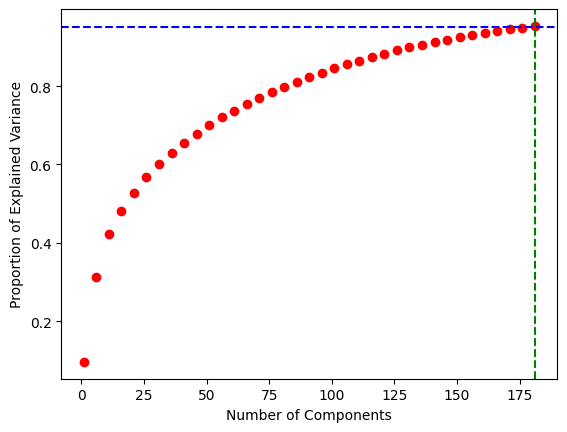

In [10]:
pca_temp = PCA().fit(dtm.toarray())
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
components = np.argmax(cumulative_variance >= 0.95) + 1
components_range = components + (components % 5) + 5

explained_var = []
for components in range(1, components_range, 5):
    pca = PCA(n_components=components)
    pca.fit(dtm.toarray())
    explained_var.append(pca.explained_variance_ratio_.sum())

print(f"Number of components to explain 95% variance: {components}")

plt.plot(range(1, components_range, 5), explained_var, "ro")
plt.axhline(y=0.95, color='b', linestyle='--', label='95% Variance')
plt.axvline(x=components, color='g', linestyle='--', label='Num Components')
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

Explained variance of the PCA step: 95.38%


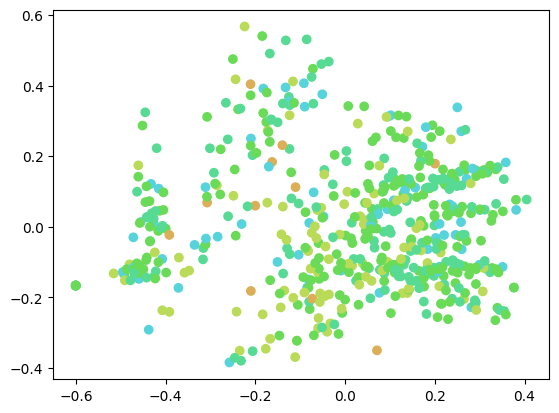

In [265]:
palette = np.array(sns.color_palette("hls", 10))
pca = PCA(n_components=components)  
pca.fit(dtm.toarray()) 
pca_dtm = pca.transform(dtm.toarray())
plt.scatter(pca_dtm[:, 0], pca_dtm[:, 1], c=palette[training_df['CRASH_SEVERITY_CD'].astype(int)])
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance of the PCA step: {explained_variance*100:.2f}%")

# Show Size and Min/Max of Values in Vector

In [266]:
X_tfidf = vec.fit_transform(training_df['concatenated_text'])
X_tfidf_dense = X_tfidf.todense()
X_tfidf_array = np.array(X_tfidf_dense)
vector_size = X_tfidf.shape[1]
print("Number of Features/Terms in vector):", vector_size)
print("Min value:", np.min(X_tfidf_array))
print("Max value:", np.max(X_tfidf_array))
print("Percentiles:", np.percentile(X_tfidf_array, [25, 50, 75, 95]))

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of Features/Terms in vector): 390
Min value: 0.0
Max value: 0.8680536272234278
Percentiles: [0.         0.         0.         0.11061341]


# Survey Model Candidates

**Linear SVM**

**Random Forest**

**K Nearest Neighbors**


In [252]:
# Model Selection Packages
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [253]:
models = [('LinearSVC', LinearSVC()), 
          ('RF', RandomForestClassifier(n_estimators=100)), 
          ]

class_balancers = [None,
                   RandomOverSampler(random_state=123), 
                   SMOTE(random_state=123), 
                   ADASYN(random_state=123), 
                   SVMSMOTE(random_state=123)]

balancer_eval = pd.DataFrame(columns=['Model', 
                                      'Balancer', 
                                      'Confusion Matrix',
                                      'Macro Avg Precision', 
                                      'Macro Avg Recall', 
                                      'Macro Avg F1'
                                      ]
                                      )

for balancer in class_balancers:
    for m_name, model in models:
        pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=CCR_Tokenizer)), 
                            ('class_balancer', balancer),
                            ('pca', PCA(n_components=components)),
                            (m_name, model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)['macro avg']
        new_row = pd.DataFrame({
                    'Model': [m_name], 
                    'Balancer': [str(balancer)], 
                    'Confusion Matrix': [conf_matrix],
                    'Macro Avg Precision': [report['precision']], 
                    'Macro Avg Recall': [report['recall']], 
                    'Macro Avg F1': [report['f1-score']]
                })
        balancer_eval = pd.concat([balancer_eval, new_row], ignore_index=True)

balancer_eval

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/tmp/ipykernel_248882/3929609397.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balancer_eval = pd.concat([balancer_eval, new_row], ignore_index=True)
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3

,Model,Balancer,Confusion Matrix,Macro Avg Precision,Macro Avg Recall,Macro Avg F1,Macro Avg Support
0,LinearSVC,None,"[[87, 4], [16, 7]]",0.740512,0.630196,0.654336,114.0
1,RF,None,"[[91, 0], [23, 0]]",0.399123,0.500000,0.443902,114.0
2,LinearSVC,RandomOverSampler(random_state=123),"[[81, 10], [14, 9]]",0.663158,0.640707,0.649770,114.0
3,RF,RandomOverSampler(random_state=123),"[[91, 0], [22, 1]]",0.902655,0.521739,0.487745,114.0
4,LinearSVC,SMOTE(random_state=123),"[[83, 8], [16, 7]]",0.652525,0.608218,0.621053,114.0
5,RF,SMOTE(random_state=123),"[[79, 12], [18, 5]]",0.554275,0.542762,0.545213,114.0
6,LinearSVC,ADASYN(random_state=123),"[[81, 10], [16, 7]]",0.623408,0.597229,0.605851,114.0
7,RF,ADASYN(random_state=123),"[[75, 16], [17, 6]]",0.543972,0.542523,0.543169,114.0
8,LinearSVC,SVMSMOTE(random_state=123),"[[87, 4], [16, 7]]",0.740512,0.630196,0.654336,114.0
9,RF,SVMSMOTE(random_state=123),"[[87, 4], [19, 4]]",0.660377,0.564978,0.570657,114.0


In [169]:
for class_balancer in [RandomOverSampler(random_state=123), SMOTE(random_state=123), ADASYN(random_state=123), SVMSMOTE(random_state=123)]:
    for m_name, model in models:
        pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=CCR_Tokenizer)), 
                            ('class_balancer', class_balancer),
                            #  ('scaler', MaxAbsScaler()),
                            ('pca', PCA(n_components=40)),
                            (m_name, model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("Model: ",m_name,class_balancer,classification_report(y_test, y_pred))
        # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        # disp.plot(cmap='Blues')
        # plt.title("Confusion Matrix")
        # plt.show()

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  SVM RandomOverSampler(random_state=123)               precision    recall  f1-score   support

           0       0.88      0.75      0.81        91
           1       0.38      0.61      0.47        23

    accuracy                           0.72       114
   macro avg       0.63      0.68      0.64       114
weighted avg       0.78      0.72      0.74       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  RF RandomOverSampler(random_state=123)               precision    recall  f1-score   support

           0       0.79      0.97      0.87        91
           1       0.00      0.00      0.00        23

    accuracy                           0.77       114
   macro avg       0.40      0.48      0.44       114
weighted avg       0.63      0.77      0.70       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  SVM SMOTE(random_state=123)               precision    recall  f1-score   support

           0       0.88      0.77      0.82        91
           1       0.38      0.57      0.46        23

    accuracy                           0.73       114
   macro avg       0.63      0.67      0.64       114
weighted avg       0.78      0.73      0.75       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  RF SMOTE(random_state=123)               precision    recall  f1-score   support

           0       0.81      0.96      0.88        91
           1       0.43      0.13      0.20        23

    accuracy                           0.79       114
   macro avg       0.62      0.54      0.54       114
weighted avg       0.74      0.79      0.74       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  SVM ADASYN(random_state=123)               precision    recall  f1-score   support

           0       0.88      0.79      0.83        91
           1       0.41      0.57      0.47        23

    accuracy                           0.75       114
   macro avg       0.64      0.68      0.65       114
weighted avg       0.78      0.75      0.76       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  RF ADASYN(random_state=123)               precision    recall  f1-score   support

           0       0.82      0.91      0.86        91
           1       0.38      0.22      0.28        23

    accuracy                           0.77       114
   macro avg       0.60      0.56      0.57       114
weighted avg       0.73      0.77      0.75       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  SVM SVMSMOTE(random_state=123)               precision    recall  f1-score   support

           0       0.87      0.91      0.89        91
           1       0.58      0.48      0.52        23

    accuracy                           0.82       114
   macro avg       0.73      0.70      0.71       114
weighted avg       0.81      0.82      0.82       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model:  RF SVMSMOTE(random_state=123)               precision    recall  f1-score   support

           0       0.83      0.95      0.88        91
           1       0.50      0.22      0.30        23

    accuracy                           0.80       114
   macro avg       0.66      0.58      0.59       114
weighted avg       0.76      0.80      0.77       114



# Peform Grid Search with Cross Validation on SVM Model

In [54]:
pipe_svc1 = Pipeline([
    ('vectorizer', vec),
    ('smote', SMOTE(random_state=123)),
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', PCA(n_components=40)),
    ('classifier', LinearSVC(random_state=123))
])
scores = cross_val_score(estimator=pipe_svc1,
                                    X=X_train,
                                    y=y_train,
                                    cv=10,
                                    n_jobs=1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  war

CV accuracy: 0.785 +/- 0.045


In [55]:
scores

array([0.80434783, 0.7826087 , 0.7173913 , 0.86956522, 0.76086957,
       0.75555556, 0.73333333, 0.77777778, 0.8       , 0.84444444])

In [58]:
pipe_svc2 = Pipeline([
    ('vec', vec),
    ('smote', SMOTE(random_state=123)),
    ('scaler', StandardScaler(with_mean=False)),    
    ('pca', PCA(n_components=40)),
    ('classifier', LinearSVC(random_state=123))
])

parameters = [
    {
        'classifier__C': [0.01, 0.1, 0.2, 0.4],
    }
]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

grid_search_svc2 = GridSearchCV(pipe_svc2, parameters, cv=kf, scoring='recall', verbose=1)
grid_search_svc2.fit(X_train, y_train)

print("Best parameters:", grid_search_svc2.best_params_)
print("Best cross-validation score:", grid_search_svc2.best_score_)


Fitting 10 folds for each of 4 candidates, totalling 40 fits


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  war

Best parameters: {'classifier__C': 0.01}
Best cross-validation score: 0.4541666666666667


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/tmp/ipykernel_248882/4072152999.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/tmp/ipykernel_248882/4072152999.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/fea

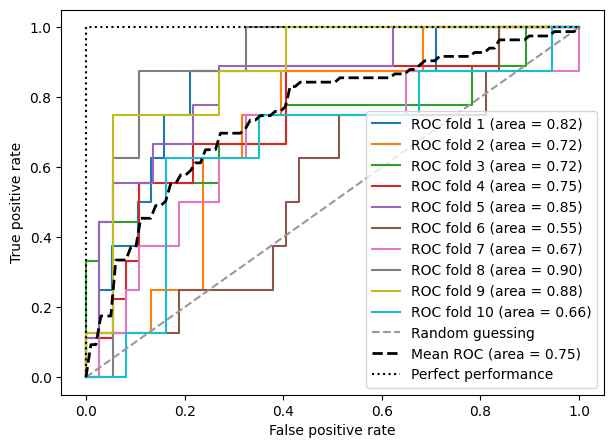

In [192]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from scipy import interp

pipe_svc3 = Pipeline([
    ('vec', vec),
    ('pca', PCA(n_components=40)),
    ('classifier', CalibratedClassifierCV(LinearSVC(random_state=123)))
])

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

kf = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=123).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kf):
    probas = pipe_svc3.fit(
       X_train[train],
       y_train[train]).predict_proba(X_train[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             label='ROC fold %d (area = %0.2f)' 
             % (i+1, roc_auc))
    
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='Random guessing')

mean_tpr /= len(kf)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         linestyle=':', 
         color='black', 
         label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

114

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


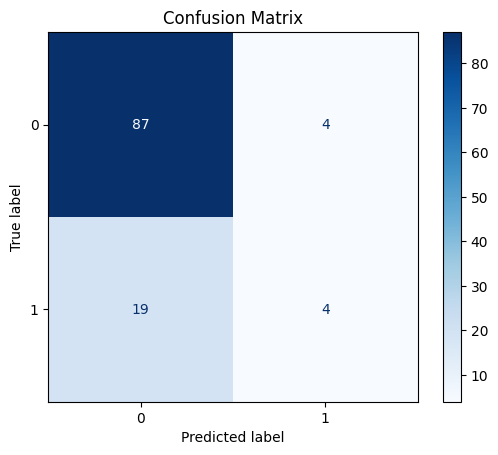

In [193]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fit the pipeline with the training data
pipe_svc3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipe_svc3.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score( 
          y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score( 
          y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score( 
          y_true=y_test, y_pred=y_pred))


Precision: 0.371
Recall: 0.565
F1: 0.448


# Model with Random Forest

In [45]:
pipe_rf1 = Pipeline([
    ('vec', vec),
    ('smote', SMOTE(random_state=123)),
    ('scaler', StandardScaler(with_mean=False)),    
    ('rfclassifier', RandomForestClassifier(random_state=123))
])

parameters = [
    {
        'rfclassifier__n_estimators': [2000,5000,10000],  # Number of trees
        'rfclassifier__max_depth': [10, 20],  # Maximum depth of each tree
        'rfclassifier__min_samples_split': [5, 10],  # Minimum number of samples required to split a node
        'rfclassifier__min_samples_leaf': [2],  # Minimum number of samples in a leaf node
        'rfclassifier__max_features': ['sqrt'],  # Number of features to consider at each split
        'rfclassifier__bootstrap': [True],  # Whether bootstrap samples are used
        'rfclassifier__class_weight': [None],  # Adjust for class imbalance
    },
]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

grid_search_rf1 = GridSearchCV(pipe_rf1, parameters, cv=kf, scoring='neg_log_loss', verbose=1)
grid_search_rf1.fit(X_train, y_train)

print("Best parameters:", grid_search_rf1.best_params_)
print("Best cross-validation score:", grid_search_rf1.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  war

Best parameters: {'rfclassifier__bootstrap': True, 'rfclassifier__class_weight': None, 'rfclassifier__max_depth': 20, 'rfclassifier__max_features': 'sqrt', 'rfclassifier__min_samples_leaf': 2, 'rfclassifier__min_samples_split': 5, 'rfclassifier__n_estimators': 2000}
Best cross-validation score: -0.41135772069017246


Best parameters: {'rfclassifier__bootstrap': True, 
                    'rfclassifier__class_weight': None, 
                    'rfclassifier__max_depth': 10, 
                    'rfclassifier__max_features': 'sqrt', 
                    'rfclassifier__min_samples_leaf': 2, 
                    'rfclassifier__min_samples_split': 10, 
                    'rfclassifier__n_estimators': 500}
Best cross-validation score: 0.47786130536130533

Best parameters: {'rfclassifier__bootstrap': True, 
                    'rfclassifier__class_weight': None, 
                    'rfclassifier__max_depth': 20, 
                    'rfclassifier__max_features': 'sqrt', 
                    'rfclassifier__min_samples_leaf': 2, 
                    'rfclassifier__min_samples_split': 5, 
                    'rfclassifier__n_estimators': 2000
                    }
Best cross-validation score: -0.41135772069017246

In [ ]:
# Count the occurrences of each value in y
y_counts = Counter(y)

# Print the counts
print(y_counts)

Counter({np.int32(4): 291, np.int32(1): 100, np.int32(0): 86, np.int32(2): 64, np.int32(3): 28})


In [ ]:
explained_var = []
for components in range(1, 100, 5):
    pca = PCA(n_components=components)
    pca.fit(dtm.toarray())
    explained_var.append(pca.explained_variance_ratio_.sum())
plt.plot(range(1, 100, 5), explained_var, "ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

KeyboardInterrupt: 

Explained variance: of the PCA step: 52.44%


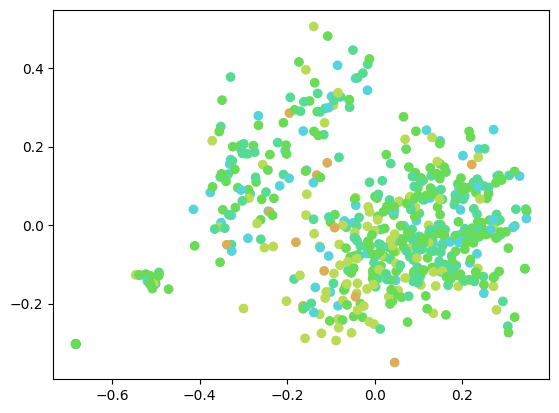

In [ ]:

components = 40

palette = np.array(sns.color_palette("hls", 10))

pca = PCA(n_components=components)  
pca.fit(dtm.toarray()) 
pca_dtm = pca.transform(dtm.toarray())

plt.scatter(pca_dtm[:, 0], pca_dtm[:, 1], c=palette[training_df['CRASH_SEVERITY_CD'].astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance: of the PCA step: {explained_variance*100:.2f}%")

Explained variance: of the PCA step: 52.44%


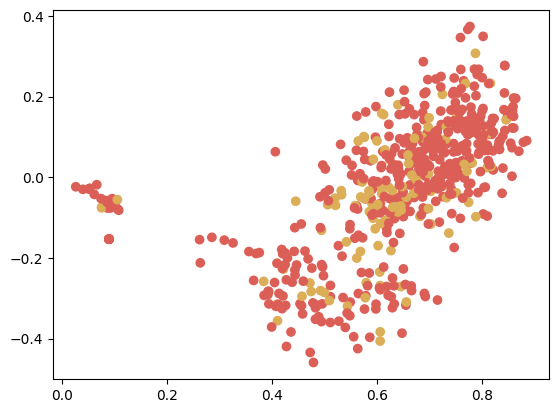

In [ ]:
components = 40

palette = np.array(sns.color_palette("hls", 10))

lsa = TruncatedSVD(n_components=components)
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)

plt.scatter(lsa_dtm[:, 0], lsa_dtm[:, 1], c=palette[training_df['CRASH_SEVERE_IND'].astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance: of the PCA step: {explained_variance*100:.2f}%")

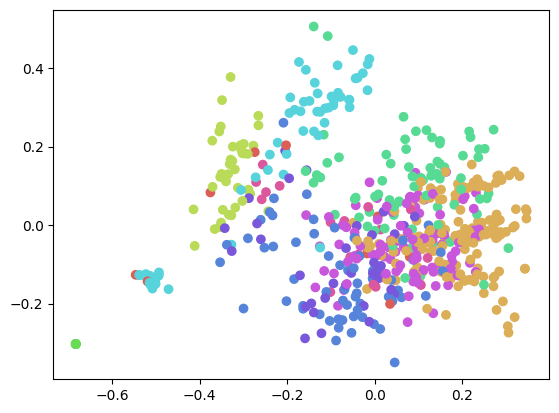

In [ ]:
palette = np.array(sns.color_palette("hls", 10))

model = KMeans(n_clusters=10,max_iter=1000)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y])

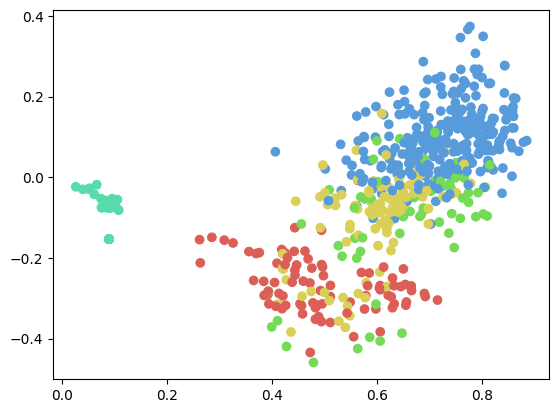

In [ ]:


palette = np.array(sns.color_palette("hls", 7))

model = KMeans(n_clusters=5,max_iter=10000)
clustered = model.fit(lsa_dtm)
centroids = model.cluster_centers_
y = model.predict(lsa_dtm)

ax = plt.subplot()
sc = ax.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[y])

In [66]:
pipe_svc2 = Pipeline([
    ('vectorizer', vec),
    ('smote', SMOTE(random_state=123)),
    ('pca', PCA(n_components=40)),
    ('classifier', LinearSVC(random_state=123))
])
scores = cross_val_score(estimator=pipe_svc2,
                                    X=X_train,
                                    y=y_train,
                                    cv=10,
                                    n_jobs=1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  war

CV accuracy: 0.771 +/- 0.049
